### **71220824_David Alan_Deteksi Kecurangan Asuransi_**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

In [3]:
dataset = pd.read_csv("[Dataset]_(Asuransi).csv")
dataset.head()

,Unnamed: 0,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,witnesses,total_claim_amount,fraud_reported,insured_sex_FEMALE,insured_sex_MALE,...,months_as_customer_groups_301-350,months_as_customer_groups_351-400,months_as_customer_groups_401-450,months_as_customer_groups_451-500,months_as_customer_groups_51-100,policy_annual_premium_groups_high,policy_annual_premium_groups_low,policy_annual_premium_groups_medium,policy_annual_premium_groups_very high,policy_annual_premium_groups_very low
0,0,53300,0,5,1,2,71610,1,0,1,...,1,0,0,0,0,0,0,1,0,0
1,1,0,0,8,1,0,5070,1,0,1,...,0,0,0,0,0,0,0,1,0,0
2,2,35100,0,7,3,3,34650,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,3,48900,-62400,5,1,2,63400,1,1,0,...,0,0,0,0,0,0,0,1,0,0
4,4,66000,-46000,20,1,1,6500,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 69 columns):
 #   Column                                  Non-Null Count  Dtype
---  ------                                  --------------  -----
 0   Unnamed: 0                              1000 non-null   int64
 1   capital-gains                           1000 non-null   int64
 2   capital-loss                            1000 non-null   int64
 3   incident_hour_of_the_day                1000 non-null   int64
 4   number_of_vehicles_involved             1000 non-null   int64
 5   witnesses                               1000 non-null   int64
 6   total_claim_amount                      1000 non-null   int64
 7   fraud_reported                          1000 non-null   int64
 8   insured_sex_FEMALE                      1000 non-null   int64
 9   insured_sex_MALE                        1000 non-null   int64
 10  insured_occupation_adm-clerical         1000 non-null   int64
 11  insured_occupation

In [5]:
dataset.isnull().sum

<bound method DataFrame.sum of      Unnamed: 0  capital-gains  capital-loss  incident_hour_of_the_day  \
0         False          False         False                     False   
1         False          False         False                     False   
2         False          False         False                     False   
3         False          False         False                     False   
4         False          False         False                     False   
..          ...            ...           ...                       ...   
995       False          False         False                     False   
996       False          False         False                     False   
997       False          False         False                     False   
998       False          False         False                     False   
999       False          False         False                     False   

     number_of_vehicles_involved  witnesses  total_claim_amount  \
0            

In [6]:
dataset.duplicated().sum()

0

In [7]:
#menghapus kolom yang tidak digunakan
dataset = dataset.drop(columns=['Unnamed: 0'])
#pembersihan data gender
dataset['insured sex'] = dataset['insured_sex_MALE'].apply(lambda x: 'Male' if x else 'Female')
dataset = dataset.drop(columns=['insured_sex_MALE', 'insured_sex_FEMALE'])
dataset.head()
# Membersihkan occupation
def get_occupation(row):
    for col in occupation_columns:
        if row[col] == 1:
            return col.replace('insured_occupation_', '')
    return 'Unknown'

occupation_columns = [
    'insured_occupation_adm-clerical', 'insured_occupation_armed-forces',
    'insured_occupation_craft-repair', 'insured_occupation_exec-managerial',
    'insured_occupation_farming-fishing', 'insured_occupation_handlers-cleaners',
    'insured_occupation_machine-op-inspct', 'insured_occupation_other-service',
    'insured_occupation_priv-house-serv', 'insured_occupation_prof-specialty',
    'insured_occupation_protective-serv', 'insured_occupation_sales',
    'insured_occupation_tech-support', 'insured_occupation_transport-moving'
]
dataset['occupation'] = dataset.apply(get_occupation, axis=1)
dataset['occupation'] = dataset['occupation'].replace('Unknown', dataset['occupation'].mode()[0])
dataset = dataset.drop(columns=occupation_columns)

# Membersihkan hobbies
hobbies_columns = [
    'insured_hobbies_chess', 'insured_hobbies_cross-fit', 'insured_hobbies_other'
]

def get_hobbies(row):
    for col in hobbies_columns:
        if row[col] == 1:
            return col.replace('insured_hobbies_', '')
    return 'Unknown'

dataset['hobbies'] = dataset.apply(get_hobbies, axis=1)
dataset['hobbies'] = dataset['hobbies'].replace('Unknown', dataset['hobbies'].mode()[0])
dataset = dataset.drop(columns=hobbies_columns)

# Membersihkan incident type
it_columns = [
    'incident_type_Multi-vehicle Collision', 'incident_type_Parked Car',
    'incident_type_Single Vehicle Collision', 'incident_type_Vehicle Theft'
]

def get_it(row):
    for col in it_columns:
        if row[col] == 1:
            return col.replace('incident_type_', '')
    return 'Unknown'

dataset['incident type'] = dataset.apply(get_it, axis=1)
# dataset['incident type'] = dataset['incident type'].replace('Unknown', dataset['incident type'].mode()[0])
dataset = dataset.drop(columns=it_columns)

# Membersihkan collision type
collType_columns = [
    'collision_type_?', 'collision_type_Front Collision',
    'collision_type_Rear Collision', 'collision_type_Side Collision'
]

def get_collType(row):
    for col in collType_columns:
        if row[col] == 1:
          if col.split('_')[2] == '?':
            return col.replace('collision_type_?','other')
          return col.replace('collision_type_', '')
    return 'Unknown'

dataset['collision type'] = dataset.apply(get_collType, axis=1)
dataset['collision type'] = dataset['collision type'].replace('Unknown', dataset['collision type'].mode()[0])
dataset = dataset.drop(columns=collType_columns)

# Membersihkan incident severity
is_columns = [
    'incident_severity_Major Damage', 'incident_severity_Minor Damage',
    'incident_severity_Total Loss', 'incident_severity_Trivial Damage'
]

def get_is(row):
    for col in is_columns:
        if row[col] == 1:
            return col.replace('incident_severity_', '')
    return 'Unknown'

dataset['incident severity'] = dataset.apply(get_is, axis=1)
dataset['incident severity'] = dataset['incident severity'].replace('Unknown', dataset['incident severity'].mode()[0])
dataset = dataset.drop(columns=is_columns)

# Membersihkan autoruties contacted
contacted_columns = [
    'authorities_contacted_Ambulance', 'authorities_contacted_Fire',
    'authorities_contacted_None', 'authorities_contacted_Other',
    'authorities_contacted_Police'
]

def get_contacted(row):
    for col in contacted_columns:
        if row[col] == 1:
            return col.replace('authorities_contacted_', '')
    return 'Unknown'

dataset['authorities contacted'] = dataset.apply(get_contacted, axis=1)
dataset['authorities contacted'] = dataset['authorities contacted'].replace('Unknown', dataset['authorities contacted'].mode()[0])
dataset = dataset.drop(columns=contacted_columns)

# Membersihkan age group
agegroup_columns = [
   'age_group_15-20', 'age_group_21-25',
   'age_group_26-30', 'age_group_31-35',
   'age_group_36-40', 'age_group_41-45',
   'age_group_46-50', 'age_group_51-55',
   'age_group_56-60', 'age_group_61-65'
]

def get_agegroup(row):
    for col in agegroup_columns:
        if row[col] == 1:
            return col.replace('age_group_', '')
    return 'Unknown'

dataset['age group'] = dataset.apply(get_agegroup, axis=1)
dataset['age group'] = dataset['age group'].replace('Unknown', dataset['age group'].mode()[0])
dataset = dataset.drop(columns=agegroup_columns)

# Membersihkan months as customer group
monthascustomergroup_columns = [
  'months_as_customer_groups_0-50', 'months_as_customer_groups_51-100',
  'months_as_customer_groups_101-150', 'months_as_customer_groups_151-200',
  'months_as_customer_groups_201-250', 'months_as_customer_groups_251-300',
  'months_as_customer_groups_301-350', 'months_as_customer_groups_351-400',
  'months_as_customer_groups_401-450', 'months_as_customer_groups_451-500'
]

def get_monthascustomergroup(row):
    for col in monthascustomergroup_columns:
        if row[col] == 1:
            return col.replace('months_as_customer_groups_', '')
    return 'Unknown'

dataset['months as customer groups'] = dataset.apply(get_monthascustomergroup, axis=1)
dataset['months as customer groups'] = dataset['months as customer groups'].replace('Unknown', dataset['months as customer groups'].mode()[0])
dataset = dataset.drop(columns=monthascustomergroup_columns)

# Membersihkan policy annual premium group
policyannualpremiumgroup_columns = [
    'policy_annual_premium_groups_high', 'policy_annual_premium_groups_low',
    'policy_annual_premium_groups_medium', 'policy_annual_premium_groups_very high',
    'policy_annual_premium_groups_very low'
]

def get_policyannualpremiumgroup(row):
    for col in policyannualpremiumgroup_columns:
        if row[col] == 1:
            return col.replace('policy_annual_premium_groups_', '')
    return 'Unknown'

dataset['policy annual premium group'] = dataset.apply(get_policyannualpremiumgroup, axis=1)
dataset['policy annual premium group'] = dataset['policy annual premium group'].replace('Unknown', dataset['policy annual premium group'].mode()[0])
dataset = dataset.drop(columns=policyannualpremiumgroup_columns)

dataset.head()


,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,witnesses,total_claim_amount,fraud_reported,insured sex,occupation,hobbies,incident type,collision type,incident severity,authorities contacted,age group,months as customer groups,policy annual premium group
0,53300,0,5,1,2,71610,1,Male,craft-repair,other,Single Vehicle Collision,Side Collision,Major Damage,Police,46-50,301-350,medium
1,0,0,8,1,0,5070,1,Male,machine-op-inspct,other,Vehicle Theft,other,Minor Damage,Police,41-45,201-250,medium
2,35100,0,7,3,3,34650,0,Female,sales,other,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,26-30,101-150,medium
3,48900,-62400,5,1,2,63400,1,Female,armed-forces,other,Single Vehicle Collision,Front Collision,Major Damage,Police,41-45,251-300,medium
4,66000,-46000,20,1,1,6500,0,Male,sales,other,Vehicle Theft,other,Minor Damage,None,41-45,201-250,high


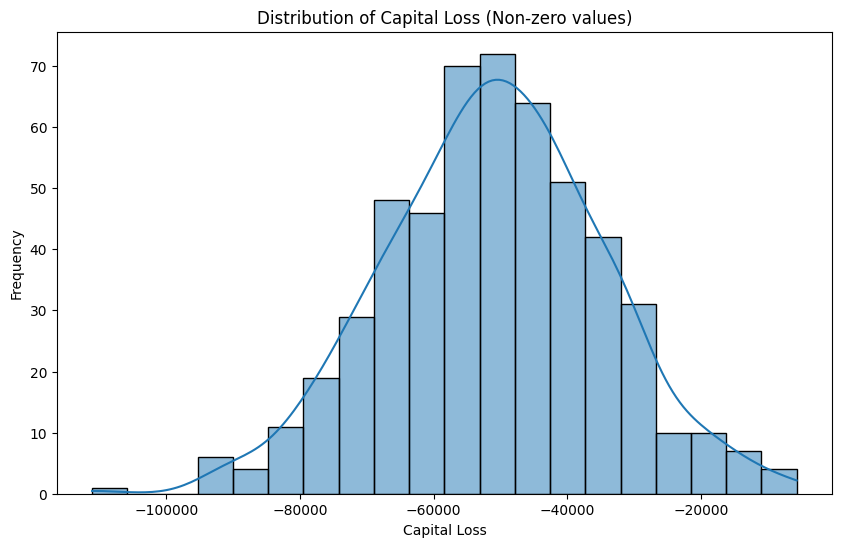

In [8]:
# Filter data untuk menghapus nilai nol dari kolom 'capital-loss'
filtered_dataset = dataset[dataset['capital-loss'] != 0]

# Menampilkan grafik capital loss tanpa nilai nol
plt.figure(figsize=(10, 6))
sns.histplot(filtered_dataset['capital-loss'], bins=20, kde=True)
plt.title('Distribution of Capital Loss (Non-zero values)')
plt.xlabel('Capital Loss')
plt.ylabel('Frequency')
plt.show()



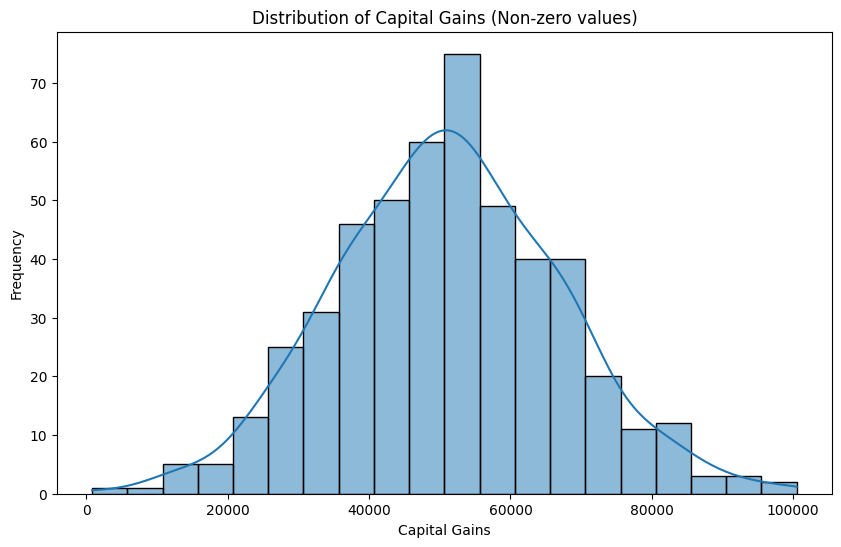

In [9]:
# Filter data untuk menghapus nilai nol dari kolom 'capital-gains'
filtered_dataset = dataset[dataset['capital-gains'] != 0]

# Menampilkan grafik capital gains  tanpa nilai nol
plt.figure(figsize=(10, 6))
sns.histplot(filtered_dataset['capital-gains'], bins=20, kde=True)
plt.title('Distribution of Capital Gains (Non-zero values)')
plt.xlabel('Capital Gains')
plt.ylabel('Frequency')
plt.show()

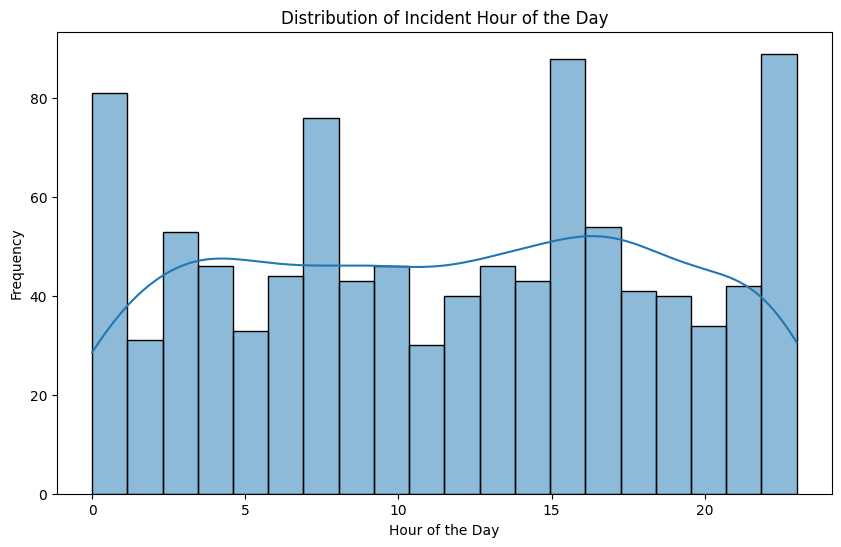

In [10]:
# Membuat plot histogram dari incident hour of the day
plt.figure(figsize=(10, 6))
sns.histplot(dataset['incident_hour_of_the_day'], bins=20, kde=True)
plt.title('Distribution of Incident Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.show()

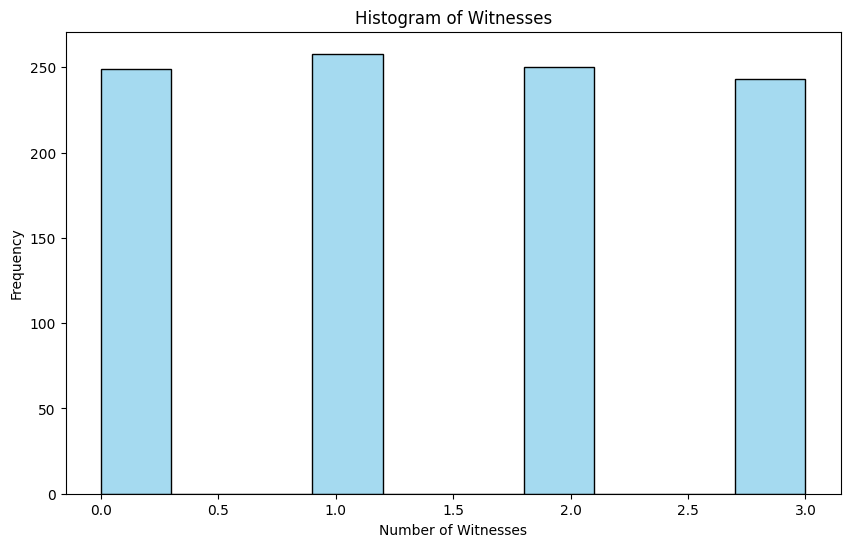

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(dataset['witnesses'], bins=10, kde=False, color='skyblue')
plt.title('Histogram of Witnesses')
plt.xlabel('Number of Witnesses')
plt.ylabel('Frequency')
plt.show()

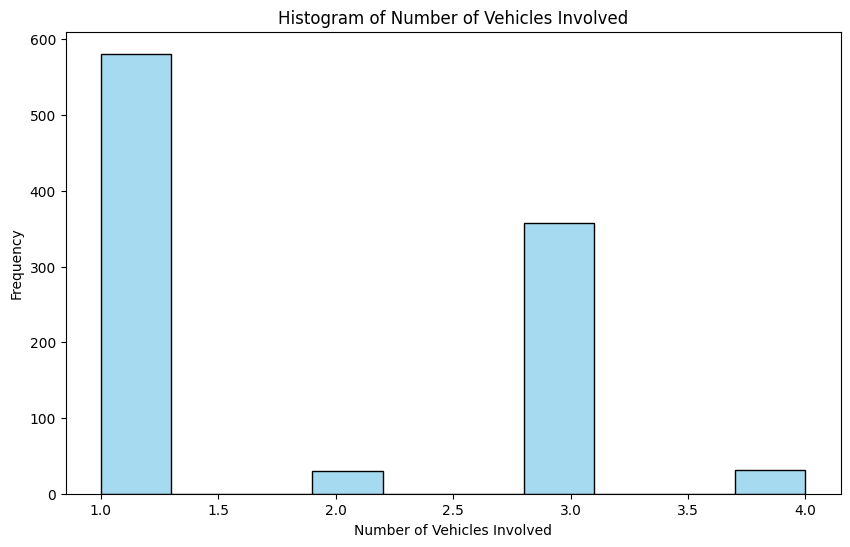

In [12]:
# Membuat plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(dataset['number_of_vehicles_involved'], bins=10, kde=False, color='skyblue')
plt.title('Histogram of Number of Vehicles Involved')
plt.xlabel('Number of Vehicles Involved')
plt.ylabel('Frequency')
plt.show()

**Fungsi untuk menampilkan prediksi**

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score



# Pisahkan fitur dan target
X = dataset.drop(columns=['fraud_reported'])
y = dataset['fraud_reported']

# One-hot encode categorical variables
X = pd.get_dummies(X)

# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Buat model Random Forest Classifier
model = RandomForestClassifier()

# Latih model
model.fit(X_train, y_train)

# Prediksi fraud pada data uji
y_pred = model.predict(X_test)

# Evaluasi akurasi model
accuracy = accuracy_score(y_test, y_pred)
print("Akurasi model:", accuracy)


Akurasi model: 0.8


**Ini adalah test case nya**

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings

# Load dataset (assuming dataset is already loaded and cleaned in a previous step)
# dataset = pd.read_csv('path_to_cleaned_dataset.csv')

# Pisahkan fitur dan target
X = dataset.drop(columns=['fraud_reported'])
y = dataset['fraud_reported']

# Konversi kolom kategorikal ke numerik
X = pd.get_dummies(X)

# Pisahkan data menjadi data training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Buat model Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Prediksi pada data test
y_pred = model.predict(X_test)

# Hitung akurasi
accuracy = accuracy_score(y_test, y_pred)

# Tampilkan akurasi
print(f'Akurasi model: {accuracy * 100:.2f}%')

# Buat test case untuk menampilkan apakah klaim termasuk penipuan atau bukan
test_case = X_test.iloc[0].values.reshape(1, -1)  # Ambil satu sampel dari data testing
prediction = model.predict(test_case)

# Tampilkan hasil prediksi untuk test case
is_fraud = 'Penipuan' if prediction[0] == 1 else 'Bukan Penipuan'
print(f'Klaim pada test case pertama: {is_fraud}')


Akurasi model: 83.00%
Klaim pada test case pertama: Bukan Penipuan


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
